# Course on Data Science and Geosciences, 2019
# Deep learning lecture

## Objective of this lab session: use auto-encoders to process MNIST dataset.


MNIST is a simple computer vision dataset. It consists of images of handwritten digits. It also includes labels for each image, telling us which digit it is. In this lab session, we're going to train a model to look at images and predict what digits they are.

First, start here with these lines of code which will download and read in the data automatically:

In [2]:
from tensorflow import keras
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


11493376/11490434 [==============================] - 0s 0us/step


The MNIST data is split into two parts: 60,000 data points of training data, 10,000 points of test data. It's essential in machine learning that we have separate data which we don't learn from so that we can make sure that what we've learned actually generalizes!

Every MNIST data point has two parts: an image of a handwritten digit and a corresponding label. "x" corresponds to images and "y" to labels. Both the training set and test set contain images and their corresponding labels.

First, we will visualize some of the data:

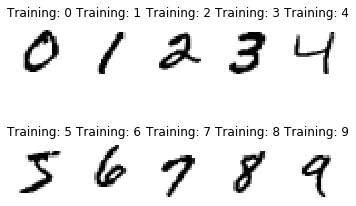

In [3]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
for i in range(10):
  plt.subplot(2, 5, i + 1)
  plt.axis('off')
  index = np.where(y_train == i)[0][0]
  plt.imshow(x_train[index,:,:], cmap=plt.cm.gray_r, interpolation='nearest')
  plt.title('Training: %i' % y_train[index])
plt.show()

#### 2) Write the code to normalize pixel intensity between 0 and 1 of images:

In [0]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

### PCA using scikitlearn



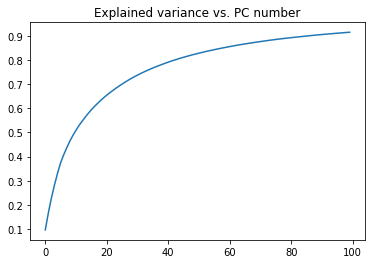

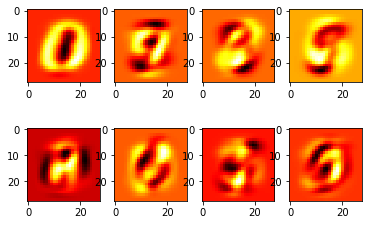

In [37]:
## PCA decomposition
from sklearn import decomposition

# PCA parameters
NbPCA    = 100
pca      = decomposition.PCA(NbPCA)

# fit PCA
pca.fit(x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2]))

# visualize PCA fit (explained variance)
plt.figure(3)
imgplot = plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Explained variance vs. PC number')
plt.show()

# visualize PCs and associated projection
PC              = np.zeros((NbPCA+1,x_train.shape[1]*x_train.shape[2])) * float('NaN')                        
PC[1:NbPCA+1,:] = pca.components_
PC[0,:]         = pca.mean_

PC             = np.reshape(PC,(NbPCA+1,x_train.shape[1],x_train.shape[2]))
PC_coef        = pca.transform(x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2]))

Nb_PCDisplay   = 8
plt.figure(4)
plt.subplot(2,Nb_PCDisplay+1,1)
imgplot = plt.imshow(PC[0,:,:])
imgplot.set_cmap('hot')
plt.title('Mean')

for kk in range(0,Nb_PCDisplay):
    plt.subplot(2,int(Nb_PCDisplay/2),kk+1)
    imgplot = plt.imshow(PC[kk+1,:,:])
    imgplot.set_cmap('hot')
    plt.axis('image')

#### 5) Auto-encoder (neural network version of PCA)

In [50]:
DimAE = 10

rec_PCA_Tr       = pca.transform(x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2]))
rec_PCA_Tr[:,DimAE:] = 0.
rec_PCA_Tr       = pca.inverse_transform(rec_PCA_Tr)
mse_PCA_Tr       = np.mean( (rec_PCA_Tr - x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2]))**2 )
var_Tr           = np.mean( x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])** 2 )
exp_var_PCA_Tr   = 1. - mse_PCA_Tr / var_Tr

rec_PCA_Tt       = pca.transform(x_test.reshape(x_test.shape[0], x_train.shape[1]*x_train.shape[2]))
rec_PCA_Tt[:,DimAE:] = 0.
rec_PCA_Tt       = pca.inverse_transform(rec_PCA_Tt)
mse_PCA_Tt       = np.mean( (rec_PCA_Tt - x_test.reshape(x_test.shape[0], x_train.shape[1]*x_train.shape[2]))**2 )
var_Tt           = np.mean( x_test.reshape(x_test.shape[0], x_train.shape[1]*x_train.shape[2])** 2 )
exp_var_PCA_Tt   = 1. - mse_PCA_Tt / var_Tt

print(".......... PCA Dim = %d"%(DimAE))
print('.... explained variance PCA (Tr) : %.2f%%'%(100.*np.cumsum(exp_var_PCA_Tr)))
print('.... explained variance PCA (Tt) : %.2f%%'%(100.*np.cumsum(exp_var_PCA_Tt)))


.......... PCA Dim = 10
.... explained variance PCA (Tr) : 69.27%
.... explained variance PCA (Tt) : 70.10%


In [51]:
## Auto-encoder (MLP)
Wpatch = 28

# encoder
input_data = keras.layers.Input(shape=(Wpatch*Wpatch,))
x          = keras.layers.Dense(5*DimAE, activation='relu')(input_data)
#x          = keras.layers.Dense(2*DimAE, activation='relu')(input_data)
#x          = keras.layers.BatchNormalization()(x)
#x          = keras.layers.Dense(3, activation='relu')(x)
encodeda   = keras.layers.Dense(DimAE, activation='linear')(x)
encoder    = keras.models.Model(input_data,encodeda)

# 
decoder_input = keras.layers.Input(shape=(DimAE,))
x             = keras.layers.Dense(10*DimAE, activation='relu')(decoder_input)
x             = keras.layers.Dense(20*DimAE, activation='relu')(x)
#x             = keras.layers.Dense(20*DimAE, activation='relu')(x)
decodedb      = keras.layers.Dense(Wpatch*Wpatch)(x)
decoder       = keras.models.Model(decoder_input,decodedb)

input_data = keras.layers.Input(shape=(Wpatch*Wpatch,))
x          = decoder(encoder(input_data))
mlp_AE     = keras.models.Model(input_data,x)

mlp_AE.summary()

# model compilation
mlp_AE.compile(loss='mse',optimizer=keras.optimizers.RMSprop(lr=1e-4))

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
model_9 (Model)              (None, 10)                39760     
_________________________________________________________________
model_10 (Model)             (None, 784)               178884    
Total params: 218,644
Trainable params: 218,644
Non-trainable params: 0
_________________________________________________________________


#### 6) Train AE model

In [52]:
# model fit
batch_size = 128
NbEpoc     = 50

history = mlp_AE.fit(x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2]),x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2]),
                      batch_size=batch_size,
                      epochs = NbEpoc,
                      verbose = 1, 
                      validation_data=(x_test.reshape(x_test.shape[0], x_train.shape[1]*x_train.shape[2]), x_test.reshape(x_test.shape[0], x_train.shape[1]*x_train.shape[2])))

# explained variance
rec_MLPAE_Tr     = mlp_AE.predict(x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2]))
mse_MLPAE_Tr     = np.mean( (rec_MLPAE_Tr - x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2]))**2 )
var_Tr           = np.mean( x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])** 2 )
exp_var_MLPAE_Tr = 1. - mse_MLPAE_Tr / var_Tr

rec_MLPAE_Tt     = mlp_AE.predict(x_test.reshape(x_test.shape[0], x_train.shape[1]*x_train.shape[2]))
mse_MLPAE_Tt     = np.mean( (rec_MLPAE_Tt - x_test.reshape(x_test.shape[0], x_train.shape[1]*x_train.shape[2]))**2 )
var_Tt           = np.mean( x_test.reshape(x_test.shape[0], x_train.shape[1]*x_train.shape[2])** 2 )
exp_var_MLPAE_Tt = 1. - mse_MLPAE_Tt / var_Tt

rec_PCA_Tr       = pca.transform(x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2]))
rec_PCA_Tr[:,DimAE:] = 0.
rec_PCA_Tr       = pca.inverse_transform(rec_PCA_Tr)
mse_PCA_Tr       = np.mean( (rec_PCA_Tr - x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2]))**2 )
var_Tr           = np.mean( x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])** 2 )
exp_var_PCA_Tr   = 1. - mse_PCA_Tr / var_Tr

rec_PCA_Tt       = pca.transform(x_test.reshape(x_test.shape[0], x_train.shape[1]*x_train.shape[2]))
rec_PCA_Tt[:,DimAE:] = 0.
rec_PCA_Tt       = pca.inverse_transform(rec_PCA_Tt)
mse_PCA_Tt       = np.mean( (rec_PCA_Tt - x_test.reshape(x_test.shape[0], x_train.shape[1]*x_train.shape[2]))**2 )
exp_var_PCA_Tt   = 1. - mse_PCA_Tt / var_Tt


print(".......... MLP Auto-encoder Dim = %d"%(DimAE))
print('.... explained variance AE (Tr)  : %.2f%%'%(100.*exp_var_MLPAE_Tr))
print('.... explained variance AE (Tt)  : %.2f%%'%(100.*exp_var_MLPAE_Tt))
print('.... explained variance PCA (Tt) : %.2f%%'%(100.*exp_var_PCA_Tr))
print('.... explained variance PCA (Tt) : %.2f%%'%(100.*exp_var_PCA_Tt))


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 32us/sample - loss: 0.0563 - val_loss: 0.0407
Epoch 2/50
60000/60000 [==============================] - 2s 26us/sample - loss: 0.0372 - val_loss: 0.0346
Epoch 3/50
60000/60000 [==============================] - 2s 28us/sample - loss: 0.0338 - val_loss: 0.0326
Epoch 4/50
60000/60000 [==============================] - 2s 28us/sample - loss: 0.0322 - val_loss: 0.0313
Epoch 5/50
60000/60000 [==============================] - 2s 30us/sample - loss: 0.0311 - val_loss: 0.0303
Epoch 6/50
60000/60000 [==============================] - 2s 27us/sample - loss: 0.0301 - val_loss: 0.0295
Epoch 7/50
60000/60000 [==============================] - 2s 27us/sample - loss: 0.0294 - val_loss: 0.0288
Epoch 8/50
60000/60000 [==============================] - 2s 31us/sample - loss: 0.0288 - val_loss: 0.0282
Epoch 9/50
60000/60000 [==============================] - 2s 28us/sample - loss: 0.0283 - val_

In [49]:
# explained variance
rec_MLPAE_Tr     = mlp_AE.predict(x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2]))
mse_MLPAE_Tr     = np.mean( (rec_MLPAE_Tr - x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2]))**2 )
var_Tr           = np.mean( x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])** 2 )
exp_var_MLPAE_Tr = 1. - mse_MLPAE_Tr / var_Tr

rec_MLPAE_Tt     = mlp_AE.predict(x_test.reshape(x_test.shape[0], x_train.shape[1]*x_train.shape[2]))
mse_MLPAE_Tt     = np.mean( (rec_MLPAE_Tt - x_test.reshape(x_test.shape[0], x_train.shape[1]*x_train.shape[2]))**2 )
var_Tt           = np.mean( x_test.reshape(x_test.shape[0], x_train.shape[1]*x_train.shape[2])** 2 )
exp_var_MLPAE_Tt = 1. - mse_MLPAE_Tt / var_Tt

rec_PCA_Tr       = pca.transform(x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2]))
rec_PCA_Tr[:,DimAE:] = 0.
rec_PCA_Tr       = pca.inverse_transform(rec_PCA_Tr)
mse_PCA_Tr       = np.mean( (rec_PCA_Tr - x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2]))**2 )
var_Tr           = np.mean( x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])** 2 )
exp_var_PCA_Tr   = 1. - mse_PCA_Tr / var_Tr

rec_PCA_Tt       = pca.transform(x_test.reshape(x_test.shape[0], x_train.shape[1]*x_train.shape[2]))
rec_PCA_Tt[:,DimAE:] = 0.
rec_PCA_Tt       = pca.inverse_transform(rec_PCA_Tt)
mse_PCA_Tt       = np.mean( (rec_PCA_Tt - x_test.reshape(x_test.shape[0], x_train.shape[1]*x_train.shape[2]))**2 )
exp_var_PCA_Tt   = 1. - mse_PCA_Tt / var_Tt


print(".......... MLP Auto-encoder Dim = %d"%(DimAE))
print('.... explained variance AE (Tr)  : %.2f%%'%(100.*exp_var_MLPAE_Tr))
print('.... explained variance AE (Tt)  : %.2f%%'%(100.*exp_var_MLPAE_Tt))
print('.... explained variance PCA (Tt) : %.2f%%'%(100.*exp_var_PCA_Tr))
print('.... explained variance PCA (Tt) : %.2f%%'%(100.*exp_var_PCA_Tt))


.......... MLP Auto-encoder Dim = 20
.... explained variance AE (Tr)  : 88.50%
.... explained variance AE (Tt)  : 88.74%
.... explained variance PCA (Tt) : 78.60%
.... explained variance PCA (Tt) : 79.34%


To study the convergence of the training step, we will plot the evolution of the accuracy for both training and testing data with respect to the epochs. The code to do this is provided below.

#### 8) Study the convergence figure and the evaluation score.

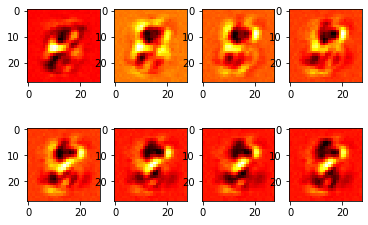

In [53]:
# Visualization of the image associated with zero-code except for one index
Nb_PCDisplay   = 8
code_mean = np.mean(encoder.predict(x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])),axis=0)
im_mean   = decoder.predict(code_mean.reshape(1,DimAE))

for kk in range(0,Nb_PCDisplay):
  code       = code_mean.reshape(1,DimAE)
  code[0,kk] = code[0,kk] + 0.001
  im_kk = decoder.predict(code) - im_mean   
  plt.subplot(2,int(Nb_PCDisplay/2),kk+1)
  imgplot = plt.imshow(im_kk.reshape(Wpatch,Wpatch))
  imgplot.set_cmap('hot')
  plt.axis('image')

